# Exercise 1
* Train and fine-tune a decision tree for the moons dataset by following these steps:
    * Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.
    * Use train_test_split() to split the dataset into a training set and a test set.
    * Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.
    * Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.

## Importing Libraries

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
import graphviz



import pandas as pd
import numpy as np

In [3]:
## create the moons dataset
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [4]:
## reading the features
X_moons

array([[ 0.9402914 ,  0.12230559],
       [ 0.12454026, -0.42477546],
       [ 0.26198823,  0.50841438],
       ...,
       [-0.24177973,  0.20957199],
       [ 0.90679645,  0.54958215],
       [ 2.08837082, -0.05050728]])

In [5]:
y_moons

array([1, 0, 0, ..., 1, 0, 1])

Observations:
* So we have 2 features in this dataset, lets callthem $x_1$ and $x_2$, and our target variable is $y$
* Lets combine them into a dataframe for easier data exploration (if needed)

In [6]:
data = pd.concat([pd.DataFrame(X_moons, columns=["x1","x2"]),pd.DataFrame(y_moons,columns=["y"])], axis=1)
data.head()

,x1,x2,y
0,0.940291,0.122306,1
1,0.124540,-0.424775,0
2,0.261988,0.508414,0
3,-0.495238,0.072589,0
4,-0.879413,0.549373,0


In [7]:
data.shape

(10000, 3)

## Train/Test Split

* Lets split the train and test before any exploration or training. 

In [8]:
training_data, testing_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
training_data.shape

(8000, 3)

In [31]:
training_data.head()

,x1,x2,y
9254,-0.564135,0.292837,0
1561,-1.160335,0.965126,0
1670,-0.065988,-0.151911,1
6087,-0.386136,0.411831,0
6669,0.053037,0.373754,1


In [10]:
testing_data.shape

(2000, 3)

Observation:
* I just realized that we don't need any data exploration for this. 
* Since we are planning to use decision trees, the algorithm doesn't need any kind of pre-processing of data. 

## Model Training 

### Split features and target variables

In [11]:
X_train = training_data.drop(columns=["y"])
X_train.head()

,x1,x2
9254,-0.564135,0.292837
1561,-1.160335,0.965126
1670,-0.065988,-0.151911
6087,-0.386136,0.411831
6669,0.053037,0.373754


In [12]:
y_train = training_data["y"]
y_train.head()

9254    0
1561    0
1670    1
6087    0
6669    1
Name: y, dtype: int64

### GridSearchCV

In [13]:
## grid search params
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 10, 20, 40, None],
    "splitter": ["best", "random"],
    "max_leaf_nodes": [10,50,100,500]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring="f1", cv=5)

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20, 40, None],
                         'max_leaf_nodes': [10, 50, 100, 500],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [15]:
print(f"Best Parameters {grid_search.best_params_}")
print(f"Best Score {grid_search.best_score_}")

Best Parameters {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 50, 'splitter': 'best'}
Best Score 0.858134168131006


Observations:
* I assumed `gini` might be a good minimizing criteria, for a simple dataset like this. A bit surprised to see `entropy` here. 
* We can still experiment with max_depth 10 and max_leaf_nodes 50. For the next experiment we'll select a the following ranges while keeping everything else same.
    * max_depth : 6,7,8,9,10
    * max_leaf_nodes : 20,25,30,35,40,45,50
* This way if there is a better combination of params that improves the `f1` score we'll know. 

In [16]:
# grid search params
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [6, 7, 8, 9, 10, None],
    "splitter": ["best", "random"],
    "max_leaf_nodes": [20, 25, 30, 35, 40, 45, 50]
}

grid_search = GridSearchCV(DecisionTreeClassifier(
    random_state=42), param_grid=param_grid, scoring="f1", cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [6, 7, 8, 9, 10, None],
                         'max_leaf_nodes': [20, 25, 30, 35, 40, 45, 50],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [17]:
print(f"Best Parameters {grid_search.best_params_}")
print(f"Best Score {grid_search.best_score_}")

Best Parameters {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 25, 'splitter': 'best'}
Best Score 0.8604760063545559


Observations:
* A tiny improvement in `f1` score not significant at all, which tells me with we might not get too much improvement with the algorithm and params. 
* We can run one more experiment with `RandomizedSearchCV` to see if there is any improvement. Although my gut tell me we won't see any significant improvement. 

### RandomizedSearchCV

In [18]:
## param distributions
param_distributions = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": randint(5, 50),  # Random depths between 5 and 50
    "splitter": ["best", "random"],
    "max_leaf_nodes": randint(10, 1000),  # Random leaf nodes between 10 and 1000
}

random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_distributions, n_iter=200, scoring="f1", n_jobs=-1)

In [19]:
random_search.fit(X_train, y_train)

/Users/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1692c2f90>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x169241b80>,
                                        'splitter': ['best', 'random']},
                   scoring='f1')

In [20]:
print(f"Best Parameters {random_search.best_params_}")
print(f"Best Score {random_search.best_score_}")

Best Parameters {'criterion': 'entropy', 'max_depth': 44, 'max_leaf_nodes': 32, 'splitter': 'best'}
Best Score 0.8595976493872785


Observations:
* As expected, more or less same `f1` score similar params. 
* We'll use the best params we got from `GridSearchCV` as our params to test against test data. 

### Best Params Model Training

In [26]:
## Best Parameters {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 25, 'splitter': 'best'}


decision_tree = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=8, max_leaf_nodes=25, splitter="best")
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=25, random_state=42)

In [27]:
## spliting test data
X_test = testing_data.drop(columns=["y"])
y_test = testing_data["y"]

In [28]:

## predicting against test

test_predictions = decision_tree.predict(X_test)

In [29]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1013
           1       0.86      0.88      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



Observations:
* As expected `f1 score` of 0.87 in the test data. Our model is good, but could be better. 

## Visualization Decision Tree

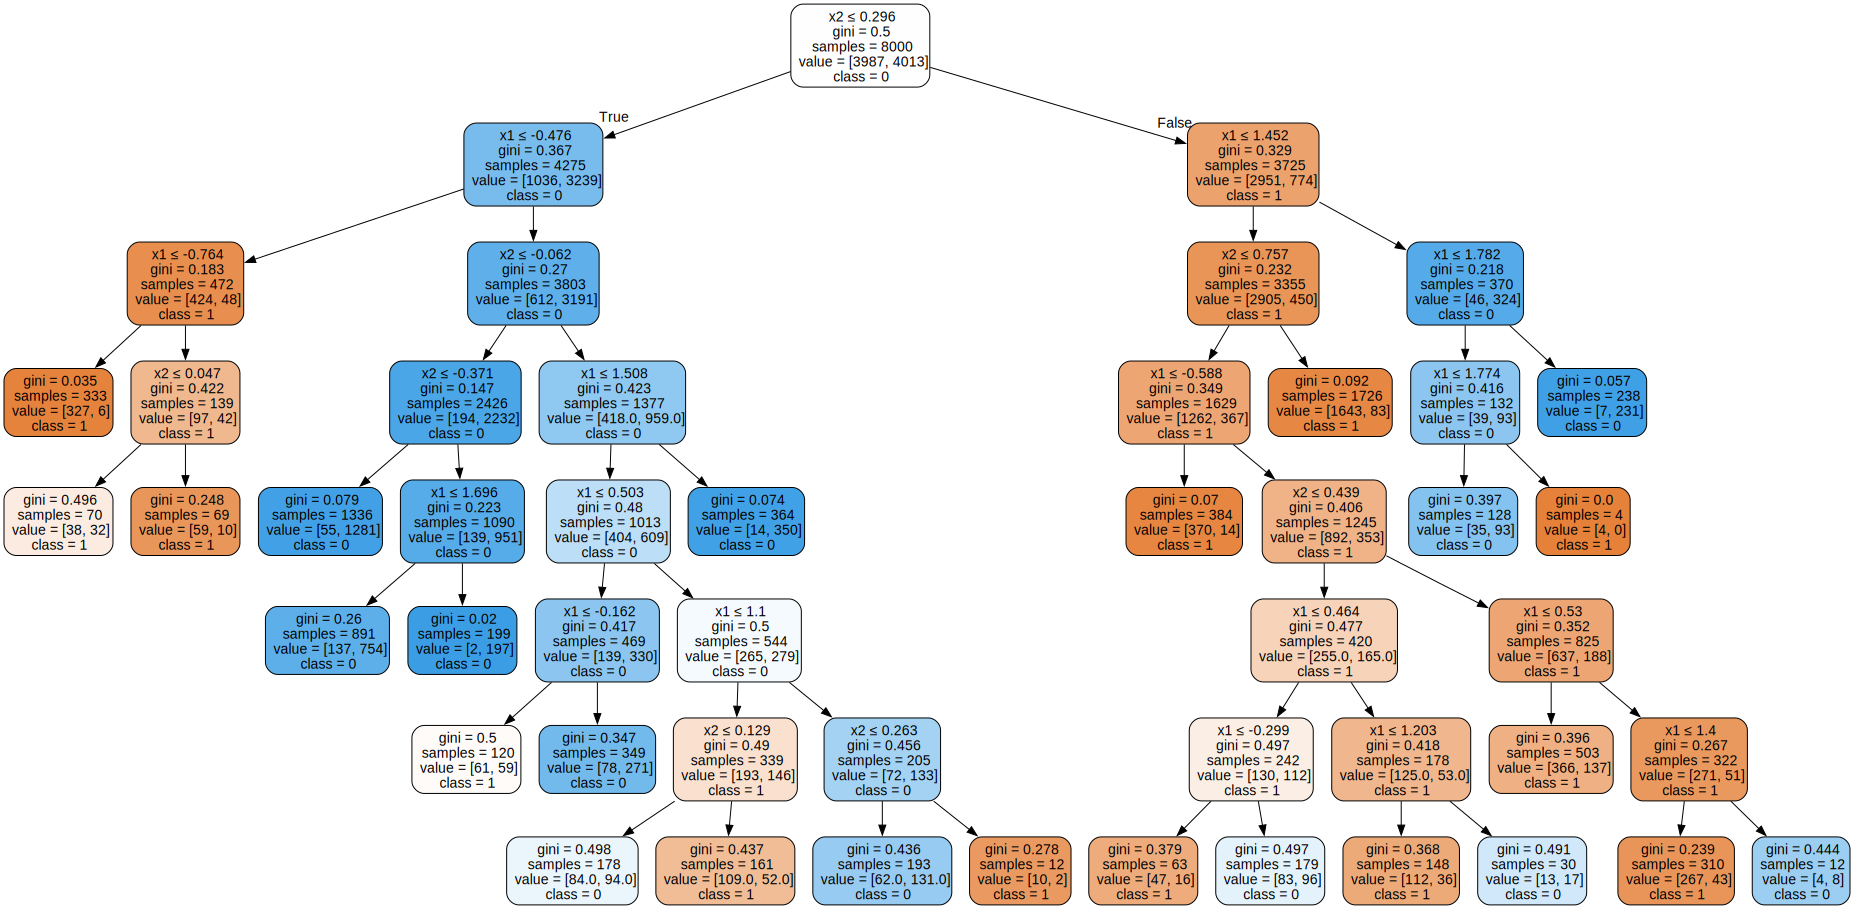

In [30]:
dot_data = export_graphviz(
    decision_tree,
    out_file=None,
    feature_names=["x1","x2"],
    class_names=["1","0"],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph

Observations:
* This make debugging wrong predictions so easy.  We can parse the tree to exactly understand how the instance was classified. 